In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(context="poster", style="ticks", palette="Set2", color_codes=True)


from astropy. io import fits
from astropy.table import Table

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

from pyFIT3D.common.constants import __c__

from neighborhood_analogs.constants import CURRENT_RUN_VERSION
from neighborhood_analogs.constants import NAMES_MAP, UNITS_MAP
from neighborhood_analogs.constants import CALIFA_CATALOGUE_PATH, CALIFA_MORPHOLOGY_PATH, CALIFA_AGN_PATH, CALIFA_VCOR_PATH
from neighborhood_analogs.constants import HUBBLE_CLASSIFICATION
from neighborhood_analogs.constants import SNA_MAP_NAMES
from neighborhood_analogs.constants import CALIFA_SCALE
from neighborhood_analogs._cmdline.find_analogs import load_catalogues, filter_general
from neighborhood_analogs.common import find_distance
from neighborhood_analogs.common import TABLE_MW


In [2]:
# load and filter catalogue

catalogue_full = load_catalogues(
    catalogue_path=CALIFA_CATALOGUE_PATH,
    morph_path=CALIFA_MORPHOLOGY_PATH,
    agn_path=CALIFA_AGN_PATH,
    vcor_path=CALIFA_VCOR_PATH,
    hubble_map=HUBBLE_CLASSIFICATION,
    verbose=False
)
catalogue = filter_general(catalogue=catalogue_full, verbose=False)

In [3]:
# read filtered model cube
par_names = [key.split()[0] for key in SNA_MAP_NAMES.keys()]

current_run_path = f"../_data/out_{CURRENT_RUN_VERSION}"
cache_path = "./_data/cache/spaxel-tables.p"

if os.path.isfile(cache_path):
    sna_table, all_table = pickle.load(open(cache_path, "rb"))
else:
    sna_tables = []
    all_tables, lik_tables = [], []
    for name, row in tqdm(catalogue.iterrows(), total=len(catalogue), desc="listing SNA hosts", ascii=True, unit="galaxy"):
        try:
            par_cube_rs = fits.getdata(f"{current_run_path}/{name}_par.cube.filtered.fits.gz")
        except FileNotFoundError:
            continue
        # read likelihood map
        lik_cube = fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 0, header=False)
        # extract relevent maps
        mod_map = lik_cube[1]
        snr_map = lik_cube[2]
        nor_map = lik_cube[3]
        chi_map = lik_cube[4]
        lik_map = lik_cube[5]
        bad_map = lik_cube[6].astype(int).astype(bool)
        # mask chi and likelihood maps
        total_mask = bad_map | (chi_map < 0) | (snr_map <= 40) | (mod_map <= 0.)
        chi_map[total_mask] = np.nan
        lik_map[total_mask] = np.nan

        # likelihood normalized by sum (volume) this is the likelihood of each pixel being a SNA relative to other pixels in the galaxy
        # some cases: if the galaxy has no pixel with likelihood above zero, then the galaxy has zero probability of hosting a SNA
        #             otherwise, the galaxy will have a 100 percent chance of hosting a SNA
        lik_map = np.divide(lik_map, np.nansum(lik_map), where=np.nansum(lik_map)!=0, out=lik_map) * 100
        # likelihood normalized by fraction of pixels having a likelihood above zero is the likelihood of each pixel being a SNA relative to other galaxies
        # some cases: this likelihood can be compared between different galaxies
        # lik_map = lik_map / np.nanmax(lik_map)
        # lik_map = lik_map * (np.nansum(lik_map[~total_mask]>0)/(~total_mask).sum()) * 100

        # read SNA spaxel table
        sna_table = Table(fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 1, header=False)).to_pandas()
        if len(sna_table) != 0:
            sna_table["name"] = name
            sna_tables.append(sna_table)

        # build spaxel and mask table
        new_shape = np.prod(lik_map.shape)
        y, x = np.where(np.ones_like(lik_map, dtype=bool))
        msk_table = total_mask.reshape(new_shape)
        
        # build chi square & likelihood table
        chi_table = chi_map.reshape(new_shape)
        lik_table = lik_map.reshape(new_shape)
        
        # build spaxel parameter table
        par_cube_rs[:, total_mask] = np.nan
        all_table = pd.DataFrame(data=par_cube_rs.reshape((par_cube_rs.shape[0],new_shape)).T, columns=par_names)
        # all spaxels positions
        all_table["name"] = name
        all_table["x"], all_table["y"] = x, y
        all_table["chi_sq"] = chi_table
        all_table["likelihood"] = lik_table
        all_table["vcor"] = row.vcor
        all_table["re_kpc"] = row.re_kpc
        # correct velocities & add kinematics to table
        all_table["LOSVD"] = all_table["LOSVD"].replace({0:1})
        all_table["vel"] = np.abs(all_table["vel"] - __c__ * row.redshift)
        all_table["vel_to_sig"] = np.abs(all_table.vel / all_table.LOSVD)

        # calculate spaxel galactocentric distance (in effective radii units)
        all_table["r_sna"] = np.nan
        for i, idx in enumerate(all_table.index):
            if msk_table[i]: continue
            all_table.loc[idx, "r_sna"] = find_distance(1.0, row.re_arc, x[i], y[i], row.xc, row.yc, row.pa, row.ellipticity, CALIFA_SCALE)
        all_tables.append(all_table[~msk_table])

    sna_table = pd.concat(sna_tables, axis="index", ignore_index=True)
    all_table = pd.concat(all_tables, axis="index", ignore_index=True)

    pickle.dump((sna_table, all_table), open(cache_path, "wb"))

In [4]:
# name = "NGC0309"
# name = "NGC5947"
# # name = "NGC5000"
# # name = sna_table.name.drop_duplicates().values[19]
# lik_cube = fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 0, header=False)
# sna_pix = fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 1, header=False)

# x, y = sna_pix.x[0], sna_pix.y[0]
# pars = catalogue.loc[name]

# _, ax = plt.subplots(figsize=(10,10))
# ax.imshow(np.sqrt(lik_cube[0]), origin="lower")
# ax.plot(x, y, "og")
# f = find_distance(1.0, pars.re_arc, x, y, pars.xc, pars.yc, pars.pa, pars.ellipticity, CALIFA_SCALE)
# print(ellipse(f, pars.re_arc, x, y, pars.xc, pars.yc, pars.pa, pars.ellipticity, CALIFA_SCALE))
# ax.add_patch(projected_circle((pars.xc,pars.yc),pars.pa,ellipticity=pars.ellipticity,radius=f*pars.re_arc, image_scale=CALIFA_SCALE))
# ax.set_title(name)

In [5]:
# calular las densidades de propiedades x vs y vs z para cada galaxia
# calcular la tabla all_table haciendo la suma de esas densidades ponderadas por la correccion por volumen
# calcular promedios radiales de cada propiedad antes de graficar densidades resueltas
# investigar parametros cinematicos: mixing scale, radial mixing, metallicity diffusion (zefeng+, carigi+2019, athausola)

<ErrorbarContainer object of 3 artists>

posx and posy should be finite values


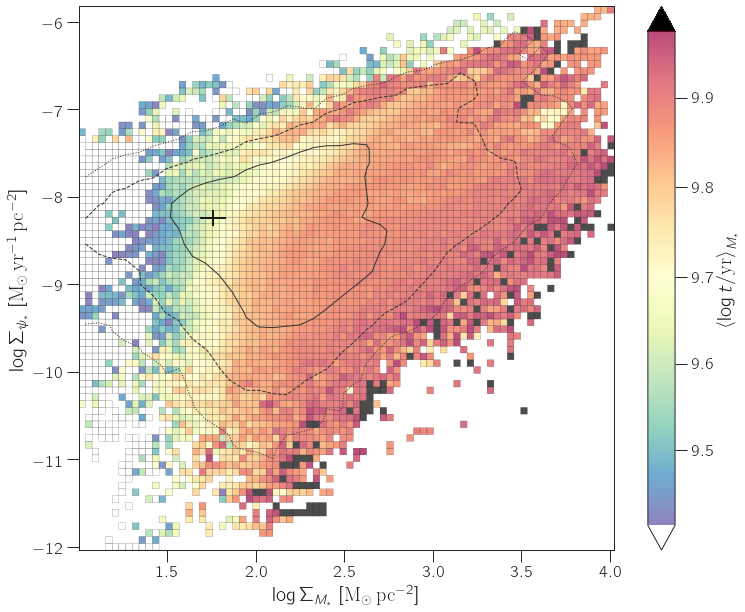

In [6]:
from scipy.stats import binned_statistic_2d
import matplotlib.colors as colors

from neighborhood_analogs.common import TABLE_MW


name_x, name_y = "Sigma_mass", "Sigma_sfr_s"
# name_x, name_y = "age_L", "Z_L"
name_z = "age_M"
data = all_table.dropna(subset=[name_x,name_y], how="any")
data = data[(data["age_M"]>8.5)&(data["Sigma_mass"]>1)&(data["r_sna"]>0)&(data["r_sna"]<=3.5)]
x, y = data[name_x], data[name_y]
lik = data.likelihood
z = data[name_z]
# z = np.log(2)-np.log(data.likelihood, where=data.likelihood!=0)
w = data.vcor

N = 40
z_min, z_max = np.percentile(z, q=(5,95))
if name_z in NAMES_MAP:
    z_cen = TABLE_MW.loc["mean", NAMES_MAP[name_z]]
    z_cen = z_cen if not np.isnan(z_cen) else np.percentile(z, q=50)
    norm_map = colors.TwoSlopeNorm(vcenter=z_cen, vmin=z_min, vmax=z_max)
else:
    norm_map = None
cmap = plt.cm.Spectral_r.with_extremes(under="1.0", over="0.0")

Z_count, xe, ye, _ = binned_statistic_2d(x, y, lik, statistic="count", bins=N)
xi = (xe[1:]+xe[:-1])/2
yi = (ye[1:]+ye[:-1])/2

Z_lik, _, _, _ = binned_statistic_2d(x, y, lik, statistic="sum", bins=(xe,ye))

Z, xe, ye, _ = binned_statistic_2d(x, y, z, statistic="median", bins=2*N)

plt.figure(figsize=(12,10))
# plt.hexbin(x, y, C=z, reduce_C_function=np.median, gridsize=2*N, mincnt=10, edgecolors="none", cmap=cmap, norm=norm_map, alpha=0.5)
plt.pcolor(xe, ye, Z.T, edgecolors="0.1", shading="flat", cmap=cmap, norm=norm_map, alpha=0.7)
cb = plt.colorbar(extend="both")
cb.set_label(f"{NAMES_MAP[name_z]}" if name_z in NAMES_MAP else name_z)

plt.contour(xi, yi, Z_count.T/Z_count.max(), levels=(0.01, 0.05, 0.32,), colors="0.2", linestyles=(":", "--", "-"), linewidths=1)
# plt.contour(xi, yi, Z_lik.T/Z_lik.max(), levels=(0.01, 0.05, 0.32), colors="0.1", linestyles=(":", "--", "-"), linewidths=1.5)
plt.xlabel(f'{NAMES_MAP[name_x]} [{UNITS_MAP[name_x]}]')
plt.ylabel(f'{NAMES_MAP[name_y]} [{UNITS_MAP[name_y]}]')
plt.errorbar(
    TABLE_MW.loc["mean", NAMES_MAP[name_x]],
    TABLE_MW.loc["mean", NAMES_MAP[name_y]],
    xerr=TABLE_MW.loc["std", NAMES_MAP[name_x]],
    yerr=TABLE_MW.loc["std", NAMES_MAP[name_y]],
    ecolor="0.1", lw=2
)

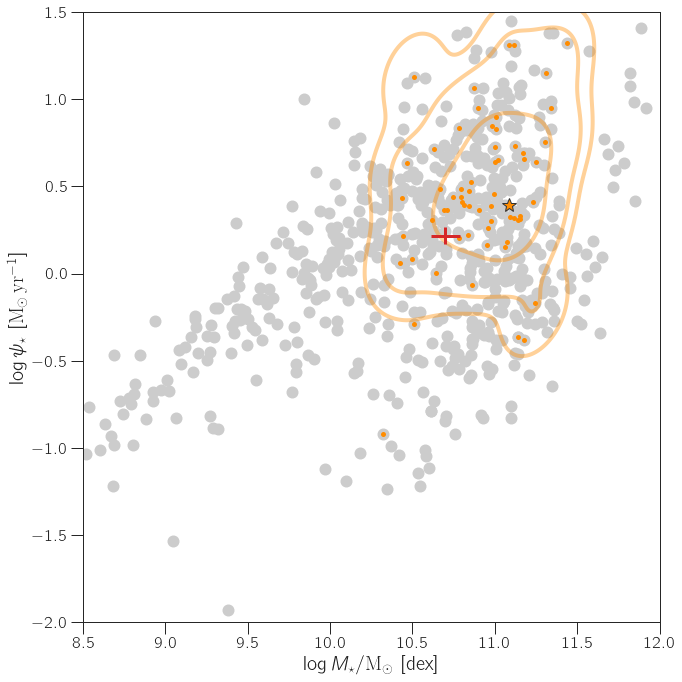

In [7]:
from scipy.stats import gaussian_kde
from MaStarChecks.plotting.analysis import density_scatter_kde, contours_from_pdf, contour_masks

# contour_masks()
# data = catalogue.loc[sna_table.name.drop_duplicates()]
data = catalogue.copy()

data["is_host"] = np.isin(data.index, sna_table.name.drop_duplicates())
data["sna_count"] = sna_table.groupby("name").count().x
data["sna_count"] = data["sna_count"].fillna(0).astype(int)

x = data.mass_star
y = data.sfr_star
z = data.sna_count

pdf = gaussian_kde(np.row_stack((x,y)), weights=z)

pdf_func = density_scatter_kde(x, y, weights=z/z.sum())
levels, X, Y, Z = contours_from_pdf(pdf_func, range_x=(x.min(),x.max()), range_y=(y.min(),y.max()), percentiles=(0,68,95,99), deltas=0.01, return_grid=True)

plt.figure(figsize=(10,10))
plt.plot(catalogue_full.mass_star, catalogue_full.sfr_star, "o", ms=12, color="0.8")
plt.plot(catalogue.loc[sna_table.name.drop_duplicates()].mass_star, catalogue.loc[sna_table.name.drop_duplicates()].sfr_star, "o", ms=5, color="darkorange")
plt.contour(X, Y, Z, levels=levels, colors="darkorange", linewidths=4, alpha=0.4)
plt.errorbar(
    TABLE_MW.loc["mean", NAMES_MAP[x.name]],
    TABLE_MW.loc["mean", NAMES_MAP[y.name]],
    xerr=TABLE_MW.loc["std", NAMES_MAP[x.name]],
    yerr=TABLE_MW.loc["std", NAMES_MAP[y.name]],
    ecolor="tab:red", lw=3
)
imax, jmax = np.where(Z==Z.max())
plt.plot(X[imax,jmax], Y[imax,jmax], "*", mew=1, mec="0.2", ms=15, color="darkorange")

plt.xlim(8.5, 12)
plt.ylim(-2.0, 1.5)
plt.xlabel(f"{NAMES_MAP['mass_star']} [{UNITS_MAP['mass_star']}]")
plt.ylabel(f"{NAMES_MAP['sfr_star']} [{UNITS_MAP['sfr_star']}]")
plt.tight_layout()

Text(0.5, 0, 'ellipticity')

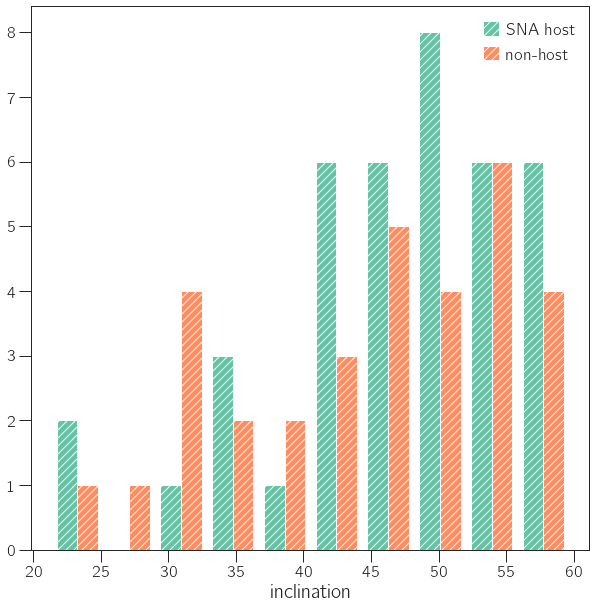

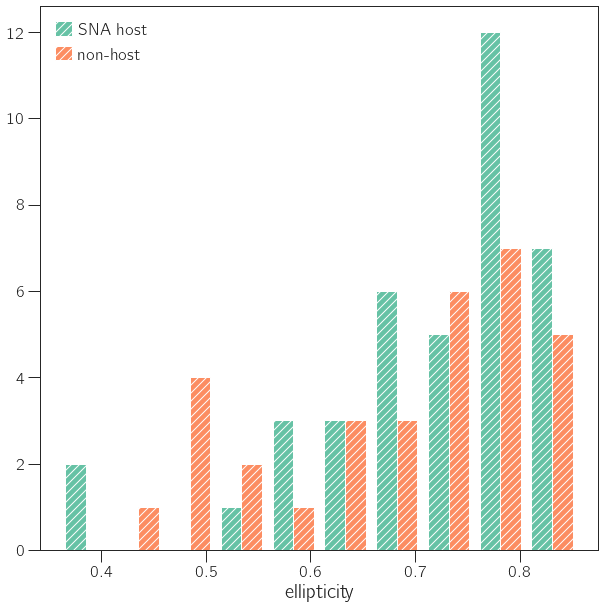

In [8]:
sigma_mask = contour_masks(pdf_func(x, y), levels=[0.50]).flatten()

host_mask = (sigma_mask&data.is_host)
norm_mask = (sigma_mask&~data.is_host)

plt.hist([data.inclination[host_mask], data.inclination[norm_mask]], label=["SNA host", "non-host"], hatch="///", lw=1)
plt.legend(loc=0, frameon=False)
plt.xlabel("inclination")

plt.figure()
plt.hist([data.ellipticity[host_mask], data.ellipticity[norm_mask]], label=["SNA host", "non-host"], hatch="///", lw=1)
plt.legend(loc=0, frameon=False)
plt.xlabel("ellipticity")

Text(0.5, 0, '$\\Phi$')

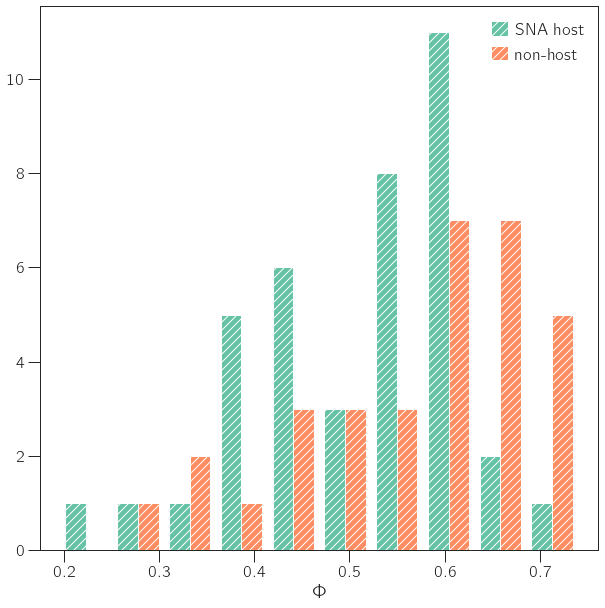

In [88]:
plt.figure()
plt.hist([(data.T80/data.T50)[host_mask], (data.T80/data.T50)[norm_mask]], label=["SNA host", "non-host"], hatch="///", lw=1)
plt.legend(loc=0, frameon=False)
plt.xlabel(r"$\Phi$")

Text(0.5, 0, '$\\Phi$')

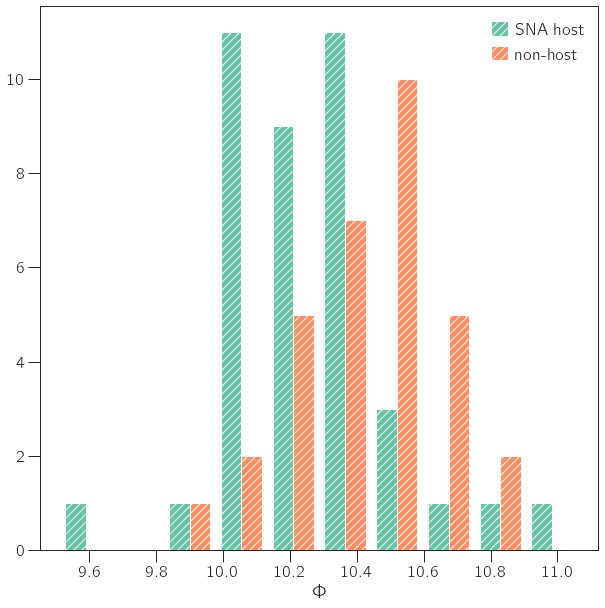

In [87]:
plt.figure()
plt.hist([(data.mass_star-np.log10(data.re_kpc))[host_mask], (data.mass_star-np.log10(data.re_kpc))[norm_mask]], label=["SNA host", "non-host"], hatch="///", lw=1)
plt.legend(loc=0, frameon=False)
plt.xlabel(r"$\Phi$")

Text(0, 0.5, 'T80')

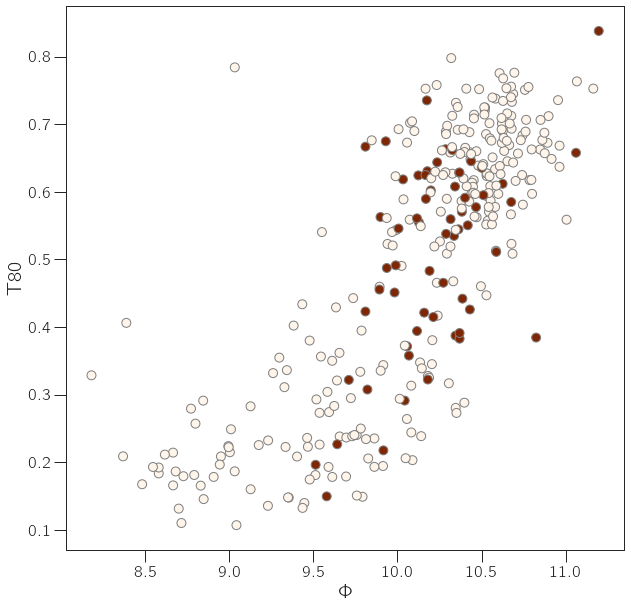

In [101]:
plt.scatter((data.mass_star-np.log10(data.re_kpc)), (data.T80/data.T50), c=data.is_host, s=80, lw=1, ec="0.5", cmap="Oranges")
plt.xlabel("$\Phi$")
plt.ylabel("T80")

Text(0, 0.5, 'T80')

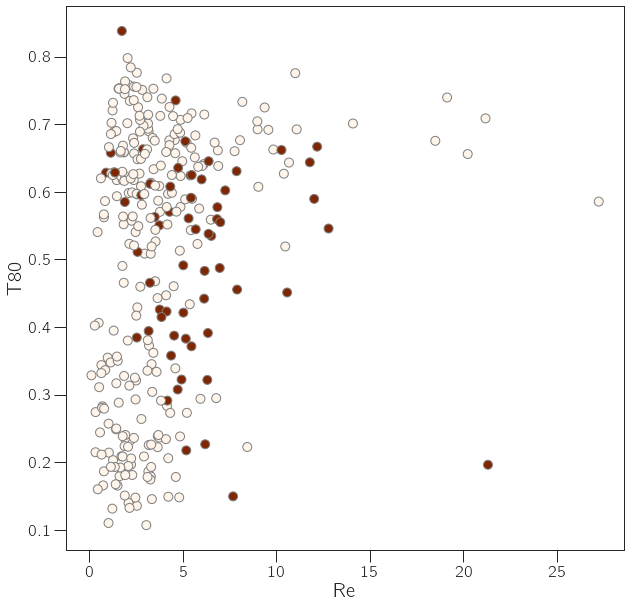

In [79]:
plt.scatter(data.re_kpc, data.T80/data.T50, c=data.is_host, s=80, lw=1, ec="0.5", cmap="Oranges")
plt.xlabel("Re")
plt.ylabel("T80")

Text(0, 0.5, 'T80')

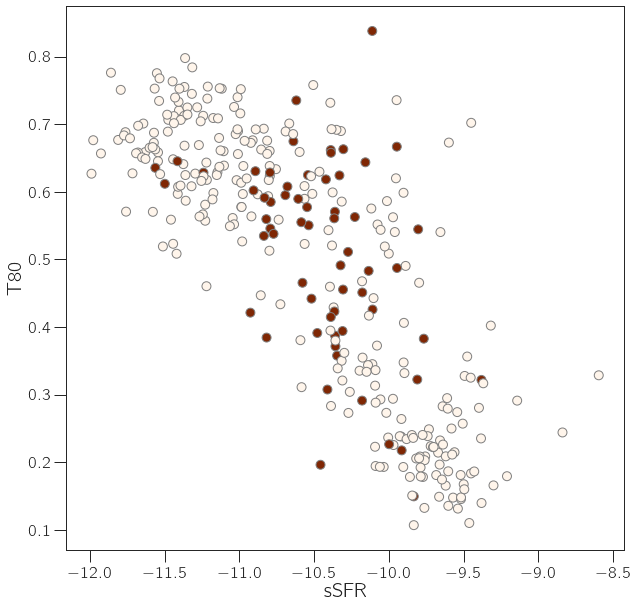

In [72]:
plt.scatter(data.sfr_star-data.mass_star, data.T80/data.T50, c=data.is_host, s=80, lw=1, ec="0.5", cmap="Oranges")
plt.xlabel("sSFR")
plt.ylabel("T80")

Text(0, 0.5, 'T80')

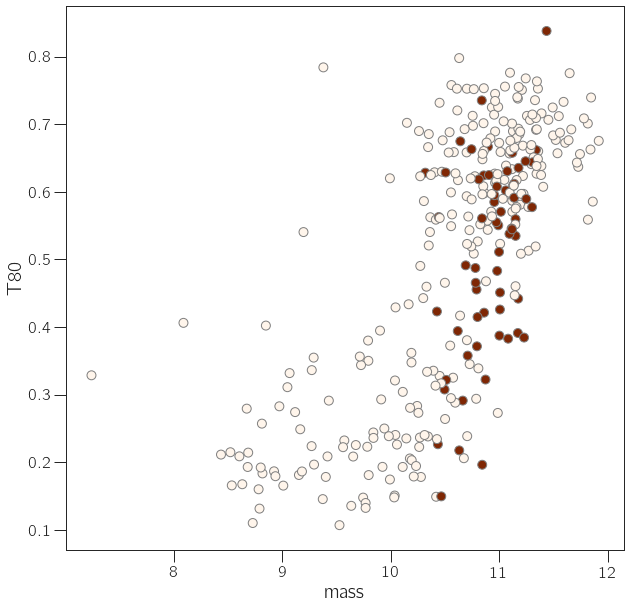

In [59]:
plt.scatter(data.mass_star, data.T80/data.T50, c=data.is_host, s=80, lw=1, ec="0.5", cmap="Oranges")
plt.xlabel("mass")
plt.ylabel("T80")

Text(0, 0.5, 'Re')

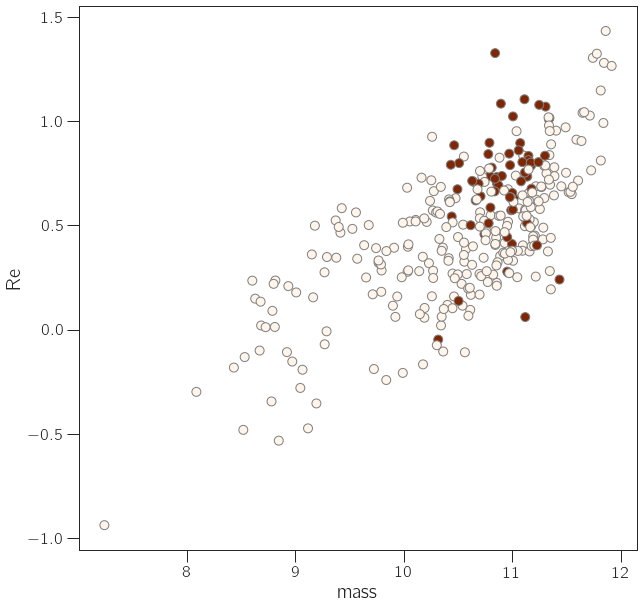

In [56]:
plt.scatter(data.mass_star, np.log10(data.re_kpc.astype(float)), c=data.is_host, s=80, lw=1, ec="0.5", cmap="Oranges")
plt.xlabel("mass")
plt.ylabel("Re")

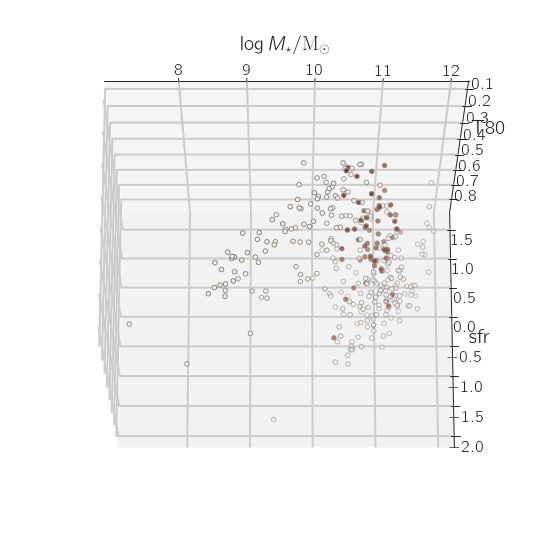

In [70]:
ax = plt.figure().add_subplot(projection="3d")
ax.scatter(data.mass_star, data.T80/data.T50, data.sfr_star.astype(float), c=data.is_host, lw=1, ec="0.5", cmap="Oranges")
ax.set_xlabel(NAMES_MAP["mass_star"])
ax.set_ylabel("T80")
ax.set_zlabel("sfr")
ax.view_init(elev=-20, azim=-90)